# Exercise 3: Neural networks in PyTorch

In this exercise you’ll implement small neural-network building blocks from scratch and use them to train a simple classifier.

You’ll cover:
- **Basic layers**: Linear, Embedding, Dropout
- **Normalization**: LayerNorm and RMSNorm
- **MLPs + residual**: composing layers into deeper networks
- **Classification**: generating a learnable dataset, implementing cross-entropy from logits, and writing a minimal training loop

As before: fill in all `TODO`s without changing function names or signatures.
Use small sanity checks and compare to PyTorch reference implementations when useful.

In [1]:
from __future__ import annotations

import torch
from torch import nn

## Basic layers

In this section you’ll implement a few core layers that appear everywhere:

### `Linear`
A fully-connected layer that follows nn.Linear conventions:  
`y = x @ Wᵀ + b`

Important details:
- Parameters should be registered as `nn.Parameter`
- Store weight as (out_features, in_features) like nn.Linear.
- The forward pass should support leading batch dimensions: `x` can be shape `(..., in_features)`

### `Embedding`
An embedding table maps integer ids to vectors:
- input: token ids `idx` of shape `(...,)`
- output: vectors of shape `(..., embedding_dim)`

This is essentially a learnable lookup table.

### `Dropout`
Dropout randomly zeroes activations during training to reduce overfitting.
Implementation details:
- Only active in `model.train()` mode
- In training: drop with probability `p` and scale the kept values by `1/(1-p)` so the expected value stays the same
- In eval: return the input unchanged

## Instructions
- Do not use PyTorch reference modules for the parts you implement (e.g. don’t call nn.Linear inside your Linear).
- You may use standard tensor ops that you learned before (matmul, sum, mean, rsqrt, indexing, etc.).
- Use a parameter initialization method of your choice. We recommend something like Xavier-uniform.


In [2]:
class Linear(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        # TODO: initialize parameters
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features))
        else:
            self.register_parameter('bias', None)
        
        with torch.no_grad():
            fan_in, fan_out = self.weight.shape[1], self.weight.shape[0]
            bound = (6 / (fan_in + fan_out))**0.5
            self.weight.uniform_(-bound, bound)
            if self.bias is not None:
                self.bias.zero_()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (..., in_features)
        return: (..., out_features)
        """
        # TODO: implement
        out = torch.matmul(x, self.weight.T)
        out += self.bias if self.bias is not None else 0
        return out
    
test_layer = Linear(5, 2)
x = torch.ones(2,5)
y = test_layer(x)
print(y)

tensor([[1.0688, 2.6755],
        [1.0688, 2.6755]], grad_fn=<AddBackward0>)


In [3]:
class Embedding(nn.Module):
    def __init__(self, num_embeddings: int, embedding_dim: int):
        super().__init__()
        # TODO: initialize
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.weight = nn.Parameter(torch.empty(num_embeddings, embedding_dim))
        with torch.no_grad():
            fan_in, fan_out = self.num_embeddings, self.embedding_dim
            bound = (6 / (fan_in + fan_out))**0.5
            self.weight.uniform_(-bound, bound)

    def forward(self, idx: torch.Tensor) -> torch.Tensor:
        """
        idx: (...,) int64
        return: (..., embedding_dim)
        """
        # TODO: implement (index into weight)
        return self.weight[idx]

test_embedding = Embedding(5, 2)
tok = 4
print(test_embedding(tok))

tensor([ 0.6696, -0.0109], grad_fn=<SelectBackward0>)


In [4]:
class Dropout(nn.Module):
    def __init__(self, p: float):
        super().__init__()
        self.p = p

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        In train mode: drop with prob p and scale by 1/(1-p).
        In eval mode: return x unchanged.
        """
        # TODO: implement without using nn.Dropout
        if not self.training or self.p == 0:
            return x
        
        mask = (torch.rand_like(x) > self.p).float() # sample values from 0 and 1 and mask out if smaller than p
        return x * mask / (1.0-self.p)


## Normalization

Normalization layers help stabilize training by controlling activation statistics.

### LayerNorm
LayerNorm normalizes each example across its **feature dimension** (the last dimension):

- compute mean and variance over the last dimension
- normalize: `(x - mean) / sqrt(var + eps)`
- apply learnable per-feature scale and shift (`weight`, `bias`)

**In this exercise, assume `elementwise_affine=True` (always include `weight` and `bias`).**  
`weight` and `bias` each have shape `(D,)`.

LayerNorm is widely used in transformers because it does not depend on batch statistics.

### RMSNorm
RMSNorm is similar to LayerNorm but normalizes using only the root-mean-square:
- `x / sqrt(mean(x^2) + eps)` over the last dimension
- usually includes a learnable scale (`weight`)
- no mean subtraction

RMSNorm is popular in modern LLMs because it's faster.


In [5]:
class LayerNorm(nn.Module):
    def __init__(
        self, normalized_shape: int, eps: float = 1e-5, elementwise_affine: bool = True
    ):
        super().__init__()
        # TODO: implement
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if elementwise_affine:
            self.weight = nn.Parameter(torch.ones(normalized_shape))
            self.bias = nn.Parameter(torch.zeros(normalized_shape))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Normalize over the last dimension.
        x: (..., D)
        """
        # TODO: implement
        centered_data = x - torch.mean(x, dim=-1, keepdim=True)
        scale = torch.sqrt(torch.var(centered_data, dim=-1, keepdim=True, unbiased=False) + self.eps)
        if self.elementwise_affine:
            out = centered_data / scale * self.weight + self.bias
        else:
            out = centered_data / scale
        
        return out
        

In [6]:
class RMSNorm(nn.Module):
    def __init__(self, normalized_shape: int, eps: float = 1e-8):
        super().__init__()
        # TODO: implement
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(normalized_shape))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        RMSNorm: x / sqrt(mean(x^2) + eps) * weight
        over the last dimension.
        """
        # TODO: implement
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        out = x / rms * self.weight
        return out

## MLPs and residual networks

Now you’ll build larger networks by composing layers.

### MLP
An MLP is a stack of `depth` Linear layers with non-linear activations (use GELU) in between.
In this exercise you’ll support:
- configurable depth
- a hidden dimension
- optional LayerNorm between layers (a common stabilization trick)

A key skill is building networks using `nn.ModuleList` / `nn.Sequential` while keeping shapes consistent.

### Transformer-style FeedForward (FFN)
A transformer block contains a position-wise feedforward network:
- `D -> 4D -> D` (by default)
- activation is typically **GELU**

This is essentially an MLP applied independently at each token position.

### Residual wrapper
Residual connections are the simplest form of “skip connection”:
- output is `x + fn(x)`

They improve gradient flow and allow training deeper networks more reliably.

In [7]:
class MLP(nn.Module):
    def __init__(
        self,
        in_dim: int,
        hidden_dim: int,
        out_dim: int,
        depth: int,
        use_layernorm: bool = False,
    ):
        super().__init__()
        # TODO: build modules (list of Linear + activation)
        # Optionally insert LayerNorm between layers.
        self.use_layernorm = use_layernorm
        self.layers = nn.ModuleList()
        
        self.layers.append(Linear(in_dim, hidden_dim))
        if use_layernorm:
            self.layers.append(LayerNorm(hidden_dim))
        
        for _ in range(depth - 1):
            self.layers.append(Linear(hidden_dim, hidden_dim))
            if use_layernorm:
                self.layers.append(LayerNorm(hidden_dim))
        
        self.output_layer = Linear(hidden_dim, out_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement
        for layer in self.layers:
            if isinstance(layer, Linear):
                x = layer(x)
                x = torch.nn.functional.gelu(x)
            elif isinstance(layer, LayerNorm):
                x = layer(x)
            
        x = self.output_layer(x)
        return x

In [8]:
class FeedForward(nn.Module):
    """
    Transformer-style FFN: D -> 4D -> D (default)
    """

    def __init__(self, d_model: int, d_ff: int | None = None):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        # TODO: create two Linear layers and choose an activation (GELU)
        self.fc = MLP(d_model, d_ff, d_model, depth=2, use_layernorm=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement
        return self.fc(x)

In [9]:
class Residual(nn.Module):
    def __init__(self, fn: nn.Module):
        super().__init__()
        # TODO: implement
        self.fn = fn

    def forward(self, x: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        # TODO: return x + fn(x, ...)
        return x + self.fn(x, *args, **kwargs)

## Classification problem

In this section you’ll put everything together in a minimal MNIST classification experiment.

You will:
1) download and load the MNIST dataset
2) implement cross-entropy from logits (stable, using log-softmax)
3) build a simple MLP-based classifier (flatten MNIST images first)
4) write a minimal training loop
5) report train loss curve and final accuracy

The goal here is not to reach state-of-the-art accuracy, but to understand the full pipeline:
data → model → logits → loss → gradients → parameter update.

### Model notes
- We want you to combine the MLP we implemented above with the classification head we define below into one model 

### MNIST notes
- MNIST images are `28×28` grayscale.
- After `ToTensor()`, each image has shape `(1, 28, 28)` and values in `[0, 1]`.
- For an MLP classifier, we flatten to a vector of length `784`.

## Deliverables
- Include a plot of your train loss curve in the video submission as well as a final accuracy. 
- **NOTE** Here we don't grade on model performance but we expect you to achieve at least 70% accuracy to confirm a correct model implementation.

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [11]:
transform = transforms.ToTensor()  # -> float32 in [0,1], shape (1, 28, 28)

train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="data", train=False, download=True, transform=transform)

# TODO: define the dataloaders

In [12]:
def cross_entropy_from_logits(
    logits: torch.Tensor,
    targets: torch.Tensor,
) -> torch.Tensor:
    """
    Compute mean cross-entropy loss from logits.

    logits: (B, C)
    targets: (B,) int64

    Requirements:
    - Use log-softmax for stability (do not use torch.nn.CrossEntropyLoss, we check this in the autograder).
    """
    # TODO: implement
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    target_log_probs = log_probs.gather(dim=1, index=targets.unsqueeze(1))
    loss = -target_log_probs.mean()
    return loss

In [13]:
class ClassificationHead(nn.Module):
    def __init__(self, d_in: int, num_classes: int):
        super().__init__()
        # TODO: implement
        self.fc = MLP(d_in, d_in, num_classes, depth=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (..., d_in)
        return: (..., num_classes) logits
        """
        # TODO: implement
        return self.fc(x)

In [18]:
@torch.no_grad()
def accuracy(model, loader, device="cpu"):
    # TODO: You can use this function to evaluate your model accuracy.
    model.eval()
    correct = 0
    total = 0
    
    for x,y in loader:
        x = x.view(x.size(0), -1)
        x,y = x.to(device), y.to(device)
        
        logits = model(x)
        
        if logits.ndim == 3:
            logits = logits[:, -1, :]
        
        preds = torch.argmax(logits, dim=-1)
        
        correct += (preds == y).sum().item()
        total += y.size(0)
        
    return correct / total

In [19]:
def train_classifier(
    model: nn.Module,
    train_data_loader: DataLoader,
    test_data_loader: DataLoader,
    lr: float,
    epochs: int,
    seed: int = 0,
) -> list[float]:
    """
    Minimal training loop for MNIST classification.

    Steps:
    - define optimizer
    - for each epoch:
        - sample minibatches
        - forward -> cross-entropy -> backward -> optimizer step
      - compute test accuracy at the end of each epoch
    - return list of training losses (one per update step)

    Requirements:
    - call model.train() during training and model.eval() during evaluation
    - do not use torch.nn.CrossEntropyLoss (use your cross_entropy_from_logits)
    """
    # TODO: implement
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    
    for epoch in range(epochs):
        model.train()
        for x,y in train_data_loader:
            x = x.view(x.size(0), -1)
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            
            logits = model(x)
            
            loss = cross_entropy_from_logits(logits, y)
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
        test_acc = accuracy(model, test_data_loader, device)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} - Test Acc: {test_acc:.4f}")
    
    return train_losses


In [20]:
model = ClassificationHead(784, 10)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)
train_losses = train_classifier(model, train_loader, test_loader, lr=1e-3, epochs=3)

Epoch 1/3 - Loss: 0.2152 - Test Acc: 0.9691
Epoch 2/3 - Loss: 0.0870 - Test Acc: 0.9786
Epoch 3/3 - Loss: 0.1585 - Test Acc: 0.9792


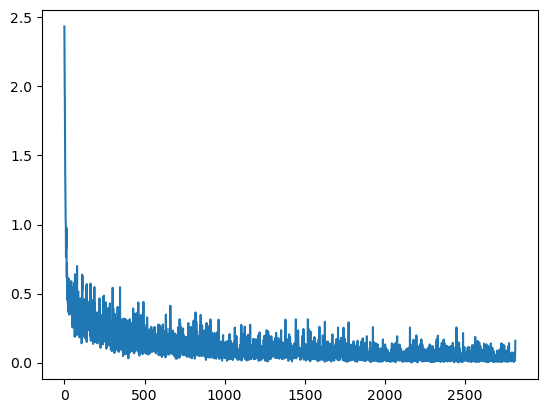

In [21]:
import matplotlib.pyplot as plt
plt.plot(train_losses)